### Low-Rank Matrix Recovery using Primal-Dual algorithms 
Given a video, we try and extract foreground (sparse) and background (low-rank) matrices from the frames.

In [159]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import time
from scipy.sparse.linalg import svds

In [113]:
# Load the data
cap = cv2.VideoCapture("highway.avi")
init_frame = 0  
num_frames = 30
frames = []
num_channels = 3
frame_num = 0

for i in range(init_frame, num_frames):
    ret, frame = cap.read()
    # convert to grayscale 
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
     
    if not ret:
        break
    frame_num += 1
    frames.append(frame)
    
cap.release()
num_frames = frame_num

### Algorithm: Principal Component Pursuit by Augmented Lagrange Multiplier for Stable PCA
PCP corresponds to the primal formulation stated in SPCA!
The paper claims that Augmented Lagrange Multiplier converges in fewer iterations as compared to Accelerated Proximal Gradient with better accuracy. Hence, we have chosen to implement this algorithm for PCP. 

In [114]:
# Initialize variables
n, m, _ = frames[0].shape
 
# Flatten the frame
max_val = np.max(np.abs(frames)) 
D = np.zeros((n*m*num_channels, num_frames))
 
for i in range(num_frames):
    D[:, i] = frames[i].flatten() 
D = D/max_val  

# Add noise
np.random.seed(0)
noise_level = 0.0
D = D + noise_level*np.random.randn(D.shape[0], D.shape[1])

# Sanity check
print(D.shape)
print(np.max(D))


(230400, 30)
1.0


In [115]:
U, S, V = np.linalg.svd(D, full_matrices=False)
print(np.dot(U, S))

[-1.05042709 -1.40512239 -1.20076522 ... -1.87667251 -2.02701064
 -2.26276624]


In [129]:

def algorithm_run(D, lamda, mu, error_tol = 1e-8, max_iter = 100, print_every = 10):
    L = np.zeros(D.shape) 
    S = np.zeros(D.shape) 
    Y = np.zeros(D.shape) 

    iter = 0    
    error = np.inf
    mu_inv = 1/mu

    # Solve for L and S
    while error > error_tol and iter < max_iter:
        # L update
        U, s, V = np.linalg.svd(D - S + mu_inv*Y, full_matrices=False)
        # Threshold singular values
        s = np.sign(s)*np.maximum(np.abs(s) - mu, 0)
        L = np.dot(U, np.dot(np.diag(s), V))

        # S update
        M = D - L + mu_inv*Y
        S = np.sign(M)*np.maximum(np.abs(M) - mu*lamda, 0)

        # Y update
        Y = Y + mu*(D - L - S)

        # Error
        error = np.linalg.norm(D - L - S, 'fro')/np.linalg.norm(D, 'fro')
        cvx_error = np.linalg.norm(L, 'nuc') + lamda*np.linalg.norm(S.flatten(), 1)
        iter += 1  
        if iter % print_every == 0:
            print(f"Iteration {iter}, error = {cvx_error}", \
                  f"L rank = {np.linalg.matrix_rank(L)}, S l1 = {np.linalg.norm(S.flatten(), 1)}")
    
    return L, S, cvx_error

In [131]:

# Cross-validation ranges for hyper-parameters
lambdas = np.logspace(-3, 3, 7)
mus = np.logspace(-3, 1, 4) # [m*n/(4*np.linalg.norm(D, 1))]

# Hyper-parameter tuning
best_error = np.inf
best_lambda = 0
best_mu = 0
for lamda in lambdas:
    for mu in mus:
        # Measure the time to run the algorithm 
        t = time.time()  
        L, S, error = algorithm_run(D, lamda, mu, max_iter = 10)
        print(f"Time to run the algorithm = {time.time() - t}", f"Error = {error}",\
               f"L rank = {np.linalg.matrix_rank(L)}", f"S L1 = {np.linalg.norm(S.flatten(), 1)}") 
        if error < best_error:
            best_error = error
            best_lambda = lamda
            best_mu = mu

print(f"Best error = {best_error}, lambda = {best_lambda}, mu = {best_mu}")


Time to run the algorithm = 0.7214479446411133 Error = 1482.5523338617045 L rank = 30 S L0 = 1779539.0
Iteration 10, error = 1478.0075124249097 L rank = 30, S l1 = 603.0555109741679
Time to run the algorithm = 3.9016640186309814 Error = 1478.0075124249097 L rank = 30 S L0 = 1873758.0
Iteration 10, error = 1407.084521402342 L rank = 13, S l1 = 14649.359199904395
Time to run the algorithm = 3.878419876098633 Error = 1407.084521402342 L rank = 13 S L0 = 4813970.0
Iteration 10, error = 1285.43656714189 L rank = 1, S l1 = 56502.93253664829
Time to run the algorithm = 3.817549228668213 Error = 1285.43656714189 L rank = 1 S L0 = 4182803.0
Time to run the algorithm = 0.6993551254272461 Error = 1482.5839637094691 L rank = 30 S L0 = 46519.0
Iteration 10, error = 1481.4258398605293 L rank = 30, S l1 = 73.87407106377445
Time to run the algorithm = 3.660472869873047 Error = 1481.4258398605293 L rank = 30 S L0 = 47804.0
Iteration 10, error = 1467.3895093088329 L rank = 30, S l1 = 1320.2640638444038


In [132]:
# Run the algorithm with the best hyper-parameters
print("Running the algorithm with the best hyper-parameters", best_lambda, best_mu)
L, S, error = algorithm_run(D, best_lambda, best_mu, error_tol = 1e-7, max_iter = 10, print_every = 1) 
print(f"Error = {error}", f"L rank = {np.linalg.matrix_rank(L)}", f"S L1 = {np.linalg.norm(S.flatten(), 1)}")

Running the algorithm with the best hyper-parameters 0.001 10.0
Iteration 1, error = 1339.1647011671428 L rank = 8, S l1 = 8479.385321193999
Iteration 2, error = 1326.534437112921 L rank = 5, S l1 = 20809.660604191296
Iteration 3, error = 1310.1158004245547 L rank = 4, S l1 = 30936.016347619377
Iteration 4, error = 1300.0980927065732 L rank = 3, S l1 = 37965.34183068526
Iteration 5, error = 1292.842240477119 L rank = 3, S l1 = 43545.77928501781
Iteration 6, error = 1288.9108516792005 L rank = 2, S l1 = 47698.92569955185
Iteration 7, error = 1286.5904191487332 L rank = 2, S l1 = 50760.94734865797
Iteration 8, error = 1285.392194756771 L rank = 2, S l1 = 53483.36648999982
Iteration 9, error = 1285.1192424882918 L rank = 2, S l1 = 55693.218687698114
Iteration 10, error = 1285.43656714189 L rank = 1, S l1 = 56502.93253664829
Error = 1285.43656714189 L rank = 1 S L1 = 56502.93253664829


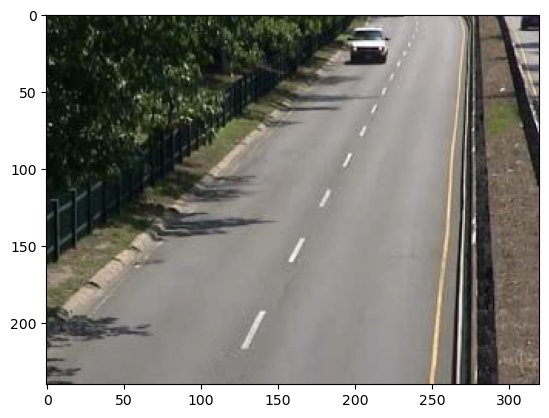

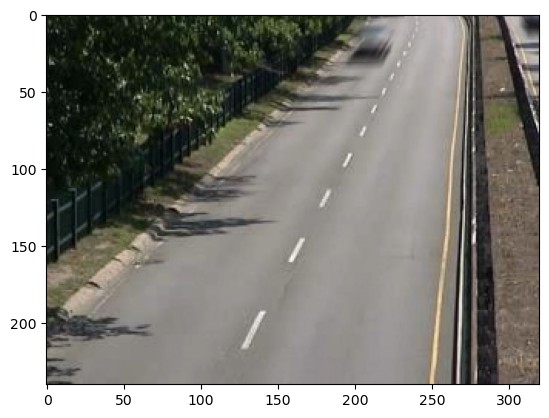

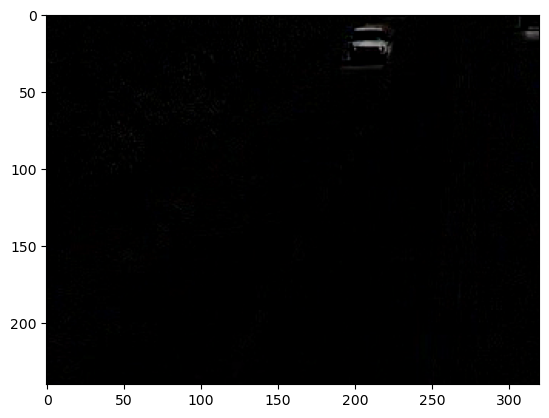

In [157]:
# Reshape the low-rank and sparse components 
L_frame = L.reshape(n, m, num_channels, num_frames)*max_val 
S_frame = S.reshape(n, m, num_channels, num_frames)*max_val 

# Clip the results
L_frame = np.clip(L_frame, 0, 255)
S_frame = np.clip(S_frame, 0, 255)

# Show the results by playing videos side by side using cv2
i = 20
plt.imshow(frames[i][ :, :, ::-1].astype(np.uint8))
plt.show()
plt.imshow(L_frame[ :, :, ::-1, i].astype(np.uint8))
plt.show()
plt.imshow(S_frame[ :, :, ::-1, i].astype(np.uint8))
plt.show()

### Algorithm: Dual Optimization


In [170]:
k = svds(D, k = 1, return_singular_vectors = True)
print(k[1])
print(k[0].shape, k[1].shape, k[2].shape)

[1235.38834431]
(230400, 1) (1,) (1, 30)


In [184]:
def minimize_dual(D, lamda, mu, error_tol = 1e-8, max_iter = 100, print_every = 10):
    L = np.zeros(D.shape) 
    S = np.zeros(D.shape) 
    L_error = np.inf
    S_error = np.inf
    ascent_error = np.inf
    L_prev = np.inf*np.ones(D.shape)
    S_prev = np.inf*np.ones(D.shape)

    lamda_inv = 1/lamda
    error_tol = 1e-8*np.linalg.norm(D, 'fro')
    ascent_error_tol = 2e-5*np.linalg.norm(D, 'fro')

    def J(Y):
        Y = Y.asfptype()
        max_s = svds(Y.astype(np.float16), k = 1, return_singular_vectors = False)
        return np.max(max_s, lamda_inv*np.linalg.norm(Y.flatten(), np.inf))
    
    def pi_2(U, Vt, M):
        D_bar = np.dot(U.T, np.dot(M, Vt.T))
        D_ = 0.5*(D_bar + D_bar.T)
        D_u, D_s, D_v = np.linalg.svd(D_)
        X = np.dot(D_u, np.dot(np.max(D_s, 0), D_v))
        return np.dot(U, np.dot(X, Vt))
    
    def pi_inf(Y):
        inf = np.linalg.norm(Y.flatten(), np.inf)
        indices = np.where(np.abs(np.abs(Y) - inf)/inf < 5e-2)
        M = np.zeros(D.shape)
        M[indices] = np.max(M[indices], 0)
        M = np.sign(Y)*M
        return M
    
    Y = np.sign(D).astype(np.float16)/J(np.sign(D).astype(np.float16))
    while ascent_error > ascent_error_tol and iter < max_iter:
        # Compute the project Dk of D onto N(Y)
        U, L2_norm, Vt = svds(Y, k = 1, return_singular_vectors = True)
        Linf_norm = lamda_inv*np.linalg.norm(Y.flatten(), np.inf)
        
        if abs(L2_norm - Linf_norm) < 1e-4:
            L = np.zeros(D.shape)
            S = np.zeros(D.shape)

            # Perform Alternating minimization
            inner_iter = 0
            while L_error > error_tol and S_error > error_tol and inner_iter < max_iter:
                L = pi_2(U, Vt, D - S)
                S = pi_inf(D - L)

                inner_iter += 1
                L_error = np.linalg.norm(L - L_prev, 'fro')
                S_error = np.linalg.norm(S - S_prev, 'fro')
                L_prev = L
                S_prev = S

            Dk = L + S

        elif L2_norm > Linf_norm:
            Dk = pi_2(U, Vt, D)
            L = D
            S = np.zeros(D.shape)
        else:
            Dk = pi_inf(D)
            L = np.zeros(D.shape)
            S = D
        
        # Line Search 
        
        Y = (Y + 0.5*(D - Dk))/J(Y + 0.5*(D - Dk))

        # Error
        error = np.linalg.norm(D - Dk, 'fro')
        L_prev = L
        S_prev = S
        iter += 1  
        if iter % print_every == 0:
            print(f"Iteration {iter}, L error = {L_error}", f"S error = {S_error}")
    
    return L, S, error

In [185]:
L, S, error = minimize_dual(D, best_lambda, best_mu, error_tol = 1e-7, max_iter = 10, print_every = 1)

AttributeError: 'numpy.ndarray' object has no attribute 'asfptype'